# RL project 

# Implementing DQN algo using Dueling networks extension and  MinAtari env

Dueling extension features two streams of computation, the **value and advantage streams**, sharing a convolutional encoder, and merged by a special aggregator

# Setup¶

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

Looking in indexes: https://download.pytorch.org/whl/cpu


# imports 

In [74]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

#  Network Architecture¶

In [75]:
# Dueling networks extention

class DuelingDQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
      
        super(DuelingDQN, self).__init__()
        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
       
        # New dueling heads
        self.value_fc = nn.Linear(128, 1)          # V(s), value stream
        self.advantage_fc = nn.Linear(128, num_actions)  # A(s, a) ,  advantage stream
        
        self.relu = nn.ReLU()
       


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = torch.flatten(x, 1) # flatten the intermediate result such that it can serve as input for the first linear layer

        # Final layer consists of 128 "rectifier" units meaning a ReLU activation
        x = self.relu(self.fc1(x))
        # Dueling streams
        value = self.value_fc(x)              # shape: (batch, 1)
        advantage = self.advantage_fc(x)      # shape: (batch, num_actions)
        
        # aggregate  value + advantage to get Q(s,a) 
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        return q_values

# vanilla DQN 

class VanillaDQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        super(VanillaDQN, self).__init__()

      
        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
       
        x = x.permute(0, 3, 1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = torch.flatten(x, 1) # flatten the intermediate result such that it can serve as input for the first linear layer

        # Final layer consists of 128 "rectifier" units meaning a ReLU activation
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out
      

# Epsilon greedy policy

In [76]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
   

    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
       
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        return Q(obs).argmax().detach().numpy()

    return policy_fn

# linear_epsilon_decay

In [77]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
  
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end
  


# linear epsilon decay Plot

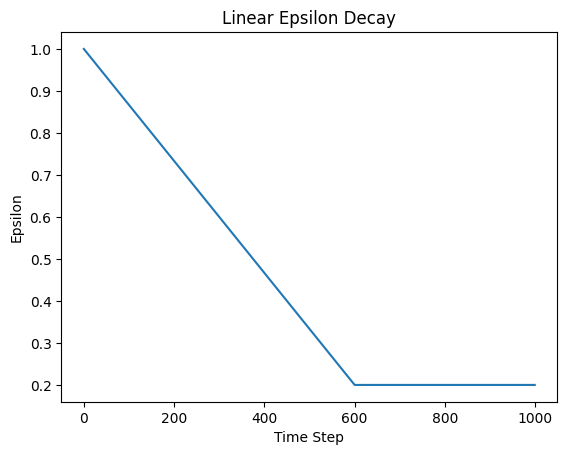

In [78]:
import matplotlib.pyplot as plt

eps_start = 1.0
eps_end = 0.2
schedule_duration = 1000

eps_values = [linear_epsilon_decay(eps_start, eps_end, t, 600) for t in range(schedule_duration)]

plt.plot(range(schedule_duration), eps_values)
plt.xlabel('Time Step')
plt.ylabel('Epsilon')
plt.title('Linear Epsilon Decay')
plt.show()

assert eps_values[0] == eps_start, "Expected eps_values[0] to be eps_start"
assert eps_values[-1] == eps_end, "Expected eps_values[-1] to be eps_end"
assert len(eps_values) == schedule_duration, "Expected eps_values to have length schedule_duration"
assert np.abs(eps_values[300] - 0.6) < 1e-10, "Expected eps_values[600] to be 0.6"
assert eps_values[600] == 0.2, "Expected eps_values[600] to be 0.6"



# Target Network

In [79]:
test_input = torch.tensor([1, 2, 3, 4], dtype=torch.float32)

# Given a neural network
net = nn.Sequential(
    nn.Linear(4, 3),
    nn.ReLU(), 
    nn.Linear(3, 1)
)
print(f"Prediction (Before): {net(test_input)}\n")


params = copy.deepcopy(net.state_dict())

print("Parameters:")
for key, value in params.items():
    print(f"- Parameter {key}:\n{value}")

# Set weight matrix of first layer to zero
net[0].weight.data.fill_(0.0)
print(f"\nPrediction (After change): {net(test_input)}\n")

# Load the old parameters
net.load_state_dict(params)
print(f"Prediction (After reload): {net(test_input)}\n")

Prediction (Before): tensor([0.2321], grad_fn=<ViewBackward0>)

Parameters:
- Parameter 0.weight:
tensor([[ 0.2624, -0.0272, -0.4274,  0.1736],
        [ 0.1321,  0.3480,  0.3849,  0.1128],
        [ 0.3191, -0.1619, -0.2035,  0.2198]])
- Parameter 0.bias:
tensor([-0.4535, -0.4120,  0.4273])
- Parameter 2.weight:
tensor([[-0.2724,  0.2049,  0.2727]])
- Parameter 2.bias:
tensor([-0.3706])

Prediction (After change): tensor([-0.2541], grad_fn=<ViewBackward0>)

Prediction (After reload): tensor([0.2321], grad_fn=<ViewBackward0>)



# Replay Buffer

In [80]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        
        
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        
       
        return len(self.data)
     

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
       
       
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)   
        self.position = (self.position + 1) % self.max_size   
      

    def sample(self, batch_size: int) -> torch.Tensor:
        
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]
        

# DQN Update

In [81]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
  
    optimizer.zero_grad()
    # Calculate the TD-Target
    with torch.no_grad():
      
        td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())
       

    # Calculate the loss.
    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))
 

    # Backpropagate the loss and step the optimizer
   
    loss.backward()
    optimizer.step()
   

# DQN Agent

In [82]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self,
            env,
            net_type="vanilla", 
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):


        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        # Initialize the Replay Buffer
        #
        self.buffer = ReplayBuffer(maxlen)
        

        self.q = self.make_network(
            net_type,
            env.observation_space.shape,
            env.action_space.n
        )
        
        self.q_target = self.make_network(
            net_type,
            env.observation_space.shape,
            env.action_space.n
        )
        
        self.q_target.load_state_dict(self.q.state_dict())
        
             

        #  ADAM optimizer for the Q-network
       
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
       

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    def make_network(self, net_type, obs_shape, n_actions):
        if net_type == "vanilla":
            return VanillaDQN(obs_shape, n_actions)
        elif net_type == "dueling":
            return DuelingDQN(obs_shape, n_actions)
        else:
            raise ValueError(f"Unknown net_type: {net_type}")


            
    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                #  Get current epsilon value
                
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
           

                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # Store sample in the replay buffer
              
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )
              

                #  Sample a mini batch from the replay buffer
                
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
               
                
                # Update the Q network
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch, 
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

# Training

In [71]:
import os

# Hyperparameters,
DISCOUNT_FACTOR = 0.99
LR = 0.00025
BATCH_SIZE = 32
EPS_START = 1.0
EPS_END = 0.01
SCHEDULE_DURATION = 20_000
UPDATE_FREQ = 100
NUM_EPISODES = 1_000
REPLAY_BUFFER_SIZE = 100_000


                    #############  Vanilla DQN training  #########


# Choose  environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

# Print observation and action space infos
print("Vanilla DQN training")
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

agent_vanilla = DQNAgent(
    env,
    net_type="vanilla",
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)

vanilla_stats = agent_vanilla.train(NUM_EPISODES)

# saving stats to resuse while analysis 


np.savez("vanilla_stats.npz",
         episode_rewards=vanilla_stats.episode_rewards,
         episode_lengths=vanilla_stats.episode_lengths)

print("vanilla stats saved to vanilla_stats.npz")                  


Vanilla DQN training
Training on MinAtar/Breakout-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(3)

Episode 100 of 1000  Time Step: 1008  Epsilon: 0.950
Episode 200 of 1000  Time Step: 2094  Epsilon: 0.896
Episode 300 of 1000  Time Step: 3274  Epsilon: 0.838
Episode 400 of 1000  Time Step: 4618  Epsilon: 0.771
Episode 500 of 1000  Time Step: 5916  Epsilon: 0.707
Episode 600 of 1000  Time Step: 7526  Epsilon: 0.628
Episode 700 of 1000  Time Step: 9278  Epsilon: 0.541
Episode 800 of 1000  Time Step: 11032  Epsilon: 0.454
Episode 900 of 1000  Time Step: 13392  Epsilon: 0.337
Episode 1000 of 1000  Time Step: 16072  Epsilon: 0.204
vanilla stats saved to vanilla_stats.npz


In [72]:
   ###### Dueling DQN training ######


# Choose  environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")
# Print observation and action space infos
print("Dueling DQN training")
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

agent_dueling = DQNAgent(
    env,
    net_type="dueling",
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)

dueling_stats = agent_dueling.train(NUM_EPISODES)

# saving stats to resuse for analysis 

np.savez("dueling_stats.npz",
         episode_rewards=dueling_stats.episode_rewards,
         episode_lengths=dueling_stats.episode_lengths)

print("Dueling stats saved to dueling_stats.npz")

Dueling DQN training
Training on MinAtar/Breakout-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(3)

Episode 100 of 1000  Time Step: 962  Epsilon: 0.952
Episode 200 of 1000  Time Step: 2054  Epsilon: 0.898
Episode 300 of 1000  Time Step: 3262  Epsilon: 0.839
Episode 400 of 1000  Time Step: 4410  Epsilon: 0.782
Episode 500 of 1000  Time Step: 5724  Epsilon: 0.717
Episode 600 of 1000  Time Step: 7550  Epsilon: 0.626
Episode 700 of 1000  Time Step: 9330  Epsilon: 0.538
Episode 800 of 1000  Time Step: 11320  Epsilon: 0.440
Episode 900 of 1000  Time Step: 13686  Epsilon: 0.323
Episode 1000 of 1000  Time Step: 16686  Epsilon: 0.174
Dueling stats saved to dueling_stats.npz


# Results 

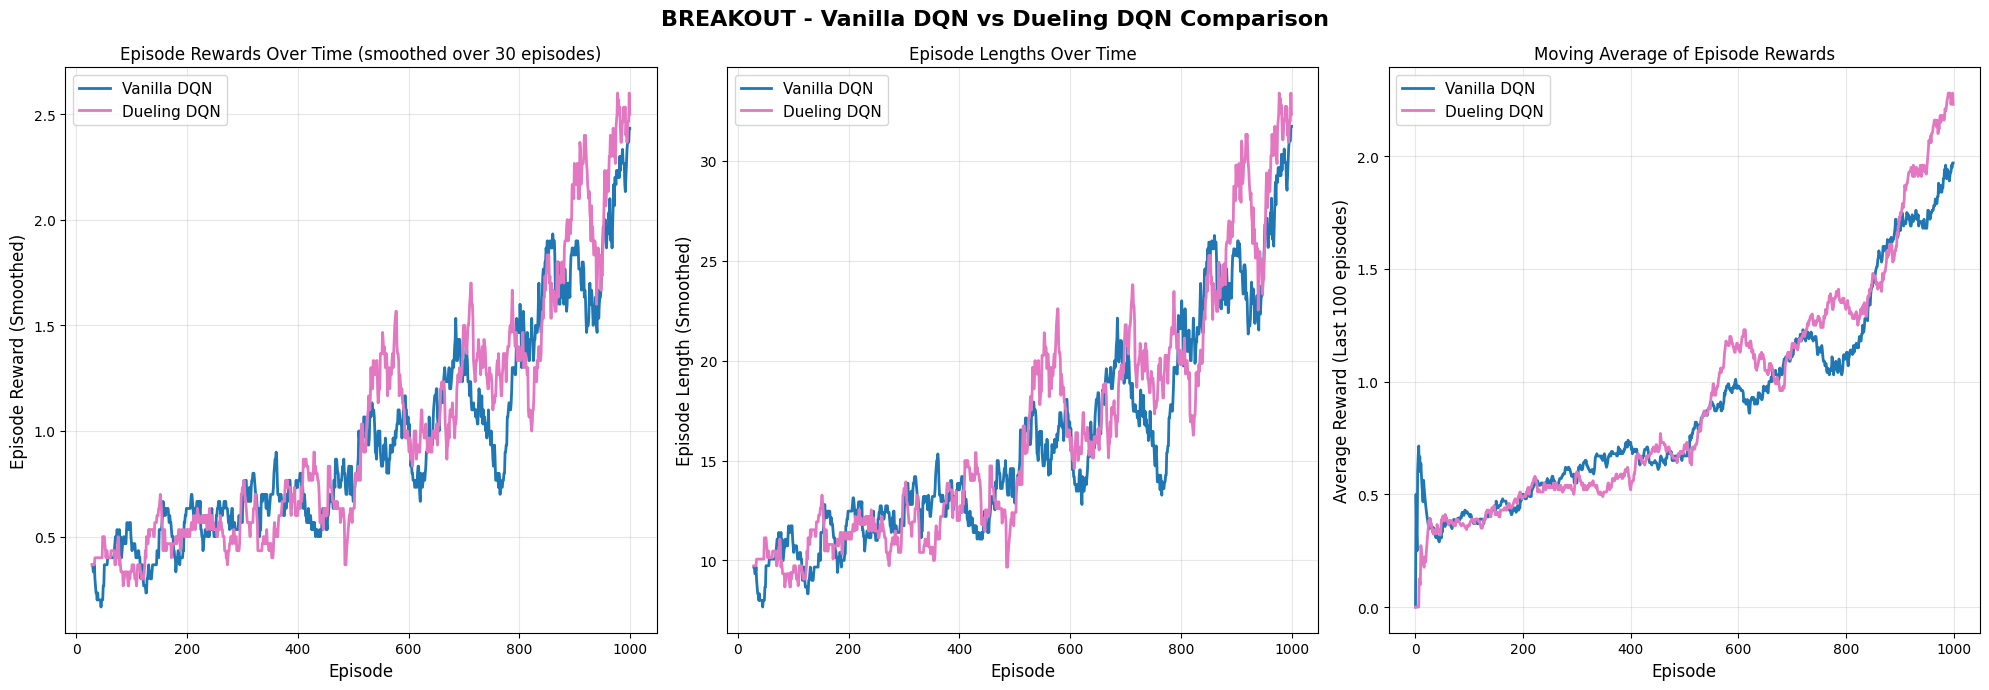

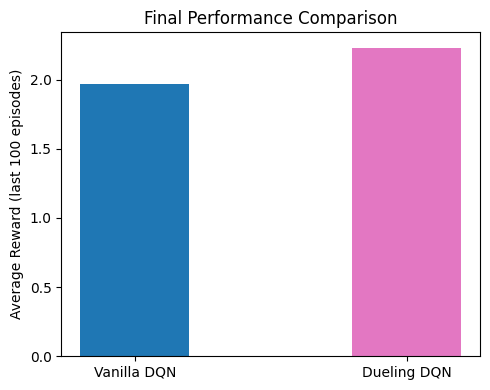

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# Comprehensive comparison plots
smoothing_window = 30

vanilla_stats = np.load("vanilla_stats.npz")
dueling_stats = np.load("dueling_stats.npz")

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('BREAKOUT - Vanilla DQN vs Dueling DQN Comparison', fontsize=16, fontweight='bold')

# Plot 1: Episode Rewards (Smoothed)
ax = axes[0]
vanilla_rewards_smoothed = pd.Series(vanilla_stats['episode_rewards']).rolling(smoothing_window, min_periods=smoothing_window).mean()
dueling_rewards_smoothed = pd.Series(dueling_stats['episode_rewards']).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax.plot(vanilla_rewards_smoothed, label='Vanilla DQN', linewidth=2, color='#1f77b4')
ax.plot(dueling_rewards_smoothed, label='Dueling DQN', linewidth=2, color='#e377c2')
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Episode Reward (Smoothed)', fontsize=12)
ax.set_title(f'Episode Rewards Over Time (smoothed over {smoothing_window} episodes)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Episode Lengths
ax = axes[1]
vanilla_lengths_smoothed = pd.Series(vanilla_stats['episode_lengths']).rolling(smoothing_window, min_periods=smoothing_window).mean()
dueling_lengths_smoothed = pd.Series(dueling_stats['episode_lengths']).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax.plot(vanilla_lengths_smoothed, label='Vanilla DQN', linewidth=2, color='#1f77b4')
ax.plot(dueling_lengths_smoothed, label='Dueling DQN', linewidth=2, color='#e377c2')
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Episode Length (Smoothed)', fontsize=12)
ax.set_title('Episode Lengths Over Time', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)


# Plot 3: Cumulative Rewards (Last 100 episodes average)
ax = axes[2]
window = 100
vanilla_cumulative = pd.Series(vanilla_stats['episode_rewards']).rolling(window, min_periods=1).mean()
dueling_cumulative = pd.Series(dueling_stats['episode_rewards']).rolling(window, min_periods=1).mean()

ax.plot(vanilla_cumulative, label='Vanilla DQN', linewidth=2, color='#1f77b4')
ax.plot(dueling_cumulative, label='Dueling DQN', linewidth=2, color='#e377c2')
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel(f'Average Reward (Last {window} episodes)', fontsize=12)
ax.set_title('Moving Average of Episode Rewards', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vanilla vs dueling comparison.png', dpi=150, bbox_inches='tight')
plt.show()


# Final performance bar chart
final_window = 100

vanilla_final = np.mean(vanilla_stats['episode_rewards'][-final_window:])
dueling_final = np.mean(dueling_stats['episode_rewards'][-final_window:])

plt.figure(figsize=(5,4))
plt.bar(["Vanilla DQN", "Dueling DQN"], [vanilla_final, dueling_final],width=0.4,color=['#1f77b4', '#e377c2'])
plt.ylabel("Average Reward (last 100 episodes)")
plt.title("Final Performance Comparison")

plt.tight_layout()
plt.savefig('bar plot.png', dpi=150, bbox_inches='tight')
plt.show()


Both agents were trained using identical hyperparameters, differing only in network architecture. The Dueling DQN demonstrates faster learning and achieves higher final rewards, indicating improved sample efficiency and stability.

# Statistical Summary

In [84]:
# Statistical Summary

print("PERFORMANCE SUMMARY")


# Calculate statistics for last 100 episodes
last_n = 100

vanilla_final_rewards = vanilla_stats['episode_rewards'][-last_n:]
dueling_final_rewards = dueling_stats['episode_rewards'][-last_n:]

print(f"\nLast {last_n} Episodes Statistics:")
print("-" * 70)
print(f"{'Metric':<30} {'Vanilla DQN':>15} {'Double DQN':>15} {'Improvement':>10}")
print("-" * 70)

# Mean reward
vanilla_mean = np.mean(vanilla_final_rewards)
dueling_mean = np.mean(dueling_final_rewards)
improvement = ((dueling_mean - vanilla_mean) / vanilla_mean * 100) if vanilla_mean != 0 else 0
print(f"{'Mean Reward':<30} {vanilla_mean:>15.2f} {dueling_mean:>15.2f} {improvement:>9.1f}%")

# Std dev
vanilla_std = np.std(vanilla_final_rewards)
dueling_std = np.std(dueling_final_rewards)
print(f"{'Std Dev':<30} {vanilla_std:>15.2f} {dueling_std:>15.2f}")

# Max reward
vanilla_max = np.max(vanilla_final_rewards)
dueling_max = np.max(dueling_final_rewards)
print(f"{'Max Reward':<30} {vanilla_max:>15.2f} {dueling_max:>15.2f}")

# Min reward
vanilla_min = np.min(vanilla_final_rewards)
dueling_min = np.min(dueling_final_rewards)
print(f"{'Min Reward':<30} {vanilla_min:>15.2f} {dueling_min:>15.2f}")

print("-" * 70)

# Overall statistics
print(f"\nOverall Statistics (All {NUM_EPISODES} Episodes):")

print(f"{'Mean Reward':<30} {np.mean(vanilla_stats['episode_rewards']):>15.2f} {np.mean(dueling_stats['episode_rewards']):>15.2f}")
print(f"{'Mean Episode Length':<30} {np.mean(vanilla_stats['episode_lengths']):>15.2f} {np.mean(dueling_stats['episode_lengths']):>15.2f}")




PERFORMANCE SUMMARY

Last 100 Episodes Statistics:
----------------------------------------------------------------------
Metric                             Vanilla DQN      Double DQN Improvement
----------------------------------------------------------------------
Mean Reward                               1.97            2.23      13.2%
Std Dev                                   1.56            1.72
Max Reward                                7.00            9.00
Min Reward                                0.00            0.00
----------------------------------------------------------------------

Overall Statistics (All 1000 Episodes):
Mean Reward                               0.97            1.03
Mean Episode Length                      16.11           16.69


# Key findings include:

    - The Dueling DQN outperformed the Vanilla DQN overall. 
    - It achieved a higher mean reward over the last 100 episodes and across all 1000 episodes, as well as longer average episode lengths, indicating more consistent and effective learning. 
    - The maximum reward was notably higher with the Dueling architecture, showing that it can reach better performance peaks, while the slight increase in standard deviation reflects occasional variability in outcomes. 
    - Overall, the Dueling network demonstrates a clear advantage in both peak performance and sustained gameplay compared to the Vanilla network.

# Learned policy in action 

In [85]:
from IPython.display import Image as IImage
import os

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)
    return filename

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs


def compare_agents(agent1, agent2, env, max_steps=1_000):
    """Run rollouts for both agents and save GIFs in a specific folder."""
    
    policy1 = make_epsilon_greedy_policy(agent1.q, num_actions=env.action_space.n)
    policy2 = make_epsilon_greedy_policy(agent2.q, num_actions=env.action_space.n)
    
    imgs1 = rendered_rollout(policy1, env, max_steps)
    imgs2 = rendered_rollout(policy2, env, max_steps)
    
    path1 = save_rgb_animation(imgs1, "vanilla.gif")
    path2 = save_rgb_animation(imgs2,"dueling.gif")
    
   
compare_agents(agent_vanilla, agent_dueling, env)
    


In [86]:
# Display GIF 

from IPython.display import display, HTML

def display_gifs_side_by_side(path1, label1, path2, label2, width=250):
    """Display two GIFs side by side with labels below each."""
    html_code = f"""
    <div style="display:flex; gap:20px; align-items:flex-start;">
        <div style="text-align:center;">
            <img src="{path1}" width="{width}"><br>
            <b>{label1}</b>
        </div>
        <div style="text-align:center;">
            <img src="{path2}" width="{width}"><br>
            <b>{label2}</b>
        </div>
    </div>
    """
    display(HTML(html_code))
# Usage
display_gifs_side_by_side("vanilla.gif","Vanilla DQN", "dueling.gif","Dueling DQN", width=250)


Dueling DQN shines when:

    Many states have similar action values    
    Rewards are sparse    
    Value of the state matters more than precise action choice

# references 

In [ ]:
https://www.emergentmind.com/papers/1511.06581
